In [1]:
# Cargamos la librerías
import geopandas as gpd
import pandas as pd
import numpy as np
from numpy import random
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import math
from scipy.stats import multivariate_normal

In [2]:
# CREAR GRID

# Limite del Grid
xmin,ymin,xmax,ymax = (0,0,10000,10000)

# Longitud de los lados
length = 1000  ### 2000 metros -->5500/110000
wide = 1000

cols = list(np.arange(xmin,xmax,wide))
rows = list(np.arange(ymin,ymax,length))

rows.reverse()
polygons = []
X,Y=[],[]
x_id,y_id=0,0
for x in cols: 
    for y in rows:
        polygons.append( Polygon([(x,y), (x+wide, y), (x+wide, y-length), (x, y-length)]))
        X.append(x_id)
        Y.append(y_id)
        y_id=y_id+1
    x_id=x_id+1
    y_id=0
        
grid = gpd.GeoDataFrame({'geometry':polygons})

# Agregar columnas de coordenadas
grid["X"]=X
grid["Y"]=Y

# Agregamos las coordenadas del centroide de cada polígono
grid_centroides=grid.geometry.centroid

# Creamos la matriz de distancia entre los centroides
M_Distancia=[]
for i in grid_centroides:
    M_Distancia.append([i.distance(j) for j in grid_centroides])
M_Distancia=np.array(M_Distancia)

# Numero de elementos en el grid
N=grid.X.count()

# Definimos la población y vivienda total del sistema
PoblacionTotal=1000000
ViviendaTotal=500000

In [3]:
# DEFINIR POBLACIÓN BÁSICA (ALEATORIA)

def Pob_Inicial_Aleatoria(G):
    G["POBTOT"]=[np.random.randint(0,PoblacionTotal) for i in range(N)]
    G["VIV"]=[np.random.randint(0,ViviendaTotal) for i in range(N)]
    G["R_DENSIDAD"]=G["POBTOT"]/G["VIV"]
    
def Poblacion_Inicial_normal(G, mu, sigma):
    # Creamos una funcion de distribución normal bivariada
    normal_bivariada = multivariate_normal(mean=mu, cov=sigma)
    
    # Distribuimos la poblacion total a las cuadrículas con la probabilidad normal bivariada
    for i in range(0,N):
        G.loc[i,"POBTOT"]=normal_bivariada.pdf([G.loc[i,"X"],G.loc[i,"Y"]])*PoblacionTotal
        G.loc[i,"VIV"]=normal_bivariada.pdf([G.loc[i,"X"],G.loc[i,"Y"]])*ViviendaTotal
    G["R_DENSIDAD"]=G["POBTOT"]/G["VIV"]
    
def Ranking_Aleatorio(G):
    # Creamos la variable de Ranking por Unidad de manera aleatoria
    G["RANKING"]=[np.random.rand() for i in range(N)]
    
def Ranking_Normal(G, mu, sigma):
    # Creamos una funcion de distribución normal bivariada
    normal_bivariada = multivariate_normal(mean=mu, cov=sigma)
    
    # Distribuimos los rankings las cuadrículas con la probabilidad normal bivariada
    for i in range(0,N):
        G.loc[i,"RANKING"]=normal_bivariada.pdf([G.loc[i,"X"],G.loc[i,"Y"]])

In [45]:
# Graficar 

def Graficar(G):
    fig, axes = plt.subplots(ncols=3, figsize=(20,10))  
    G.plot(column='POBTOT', legend=True, ax=axes[0], edgecolor='white')
    axes[0].set_title('Población')
    G.plot(column='R_DENSIDAD', legend=True, ax=axes[1])
    axes[1].set_title('Densidad')
    G.plot(column='RANKING', legend=True, ax=axes[2])
    axes[2].set_title('Ranking')
    plt.show()

In [24]:
# PARAMETROS

# Crecimiento poblacional
alpha = 0.02
# Crecimiento vivienda
beta = 0.01


# Función sigmoide que representa la probabilidad de emigración en función de saturación 
delta=5  # Recorre a la derecha la función sigmoide
f_sigmoide = lambda x: 1/(1+math.exp(-x+delta))

In [25]:
def Actualizacion(G, iteraciones):     
    G_Nueva=G
       
    
    # Modelación de la dinámica poblacional
    for t in range(0,iteraciones):
        Natural_Pob=G_Nueva["POBTOT"]*alpha   # Calculamos el crecimiento natural de la poblacion
        Natural_VIV=G_Nueva["VIV"]*beta       # Calculamos el crecimiento natural de la vivienda
        
        # A partir de la saturación definimos una tasa de emigración y el total de la población que sale de cada AGEB
        Tasa_Emigracion=[f_sigmoide(G_Nueva.loc[i,"R_DENSIDAD"]) for i in range(0,N)]
        Total_Emigracion=Tasa_Emigracion*G_Nueva.POBTOT
        Indice_Saturacion= 1-np.array(Tasa_Emigracion)
                
        # Distribuimos la emigración a los diferentes AGEB a partir del ranking y la distancia
        Matriz_Inmigracion=[]
        for i in range(0,N):
            # Ajustamos el ranking en términos de la distancia y normalizamos para tener una probabilidad
            Ranking_Actualizado = [j if j!=np.inf else 0 for j in G_Nueva["RANKING"]/M_Distancia[i]]
            Ranking_Actualizado = Ranking_Actualizado
            Ranking_Actualizado = Ranking_Actualizado/np.array(Ranking_Actualizado).sum()
            Ranking_Actualizado = Ranking_Actualizado*Indice_Saturacion
            Inmigracion = Ranking_Actualizado*Total_Emigracion[i]
            Matriz_Inmigracion.append(Inmigracion)  
            
        #Calculamos la población total que inmigra a un AGEB
        Matriz_Inmigracion=np.array(Matriz_Inmigracion)
        Inmigracion_Recibida=[Matriz_Inmigracion[:, j].sum() for j in range(0,N)]
        
        # Actualizar la población, vivienda y densidad
        G_Nueva["POBTOT"]=G_Nueva["POBTOT"]+Natural_Pob-Total_Emigracion+Inmigracion_Recibida
        G_Nueva["VIV"]=G_Nueva["VIV"]+Natural_VIV
        G_Nueva["R_DENSIDAD"]=G_Nueva["POBTOT"]/G_Nueva["VIV"]

    return G_Nueva

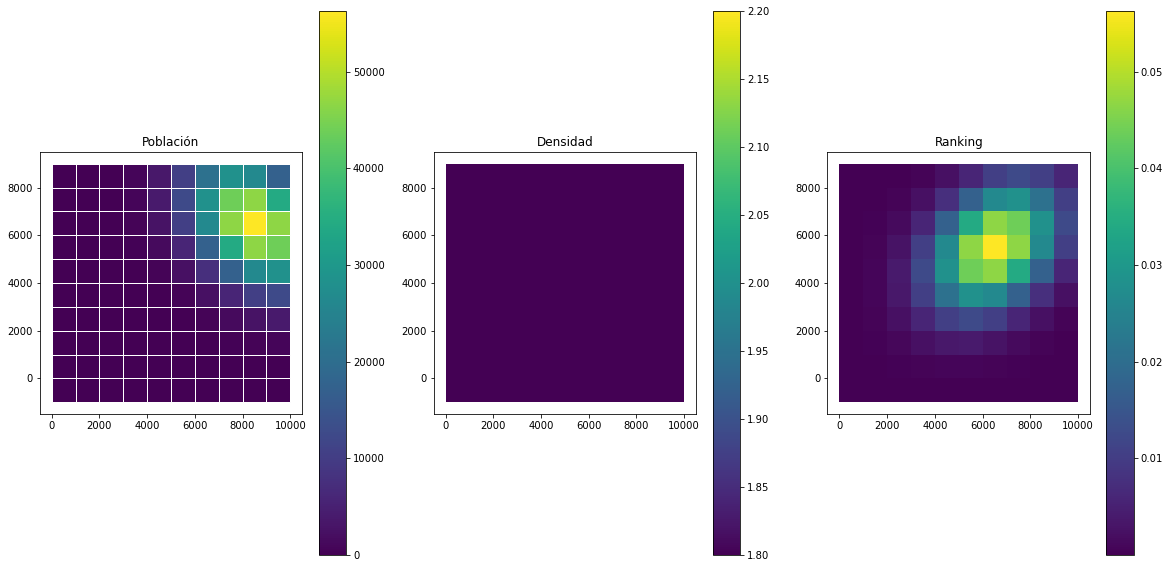

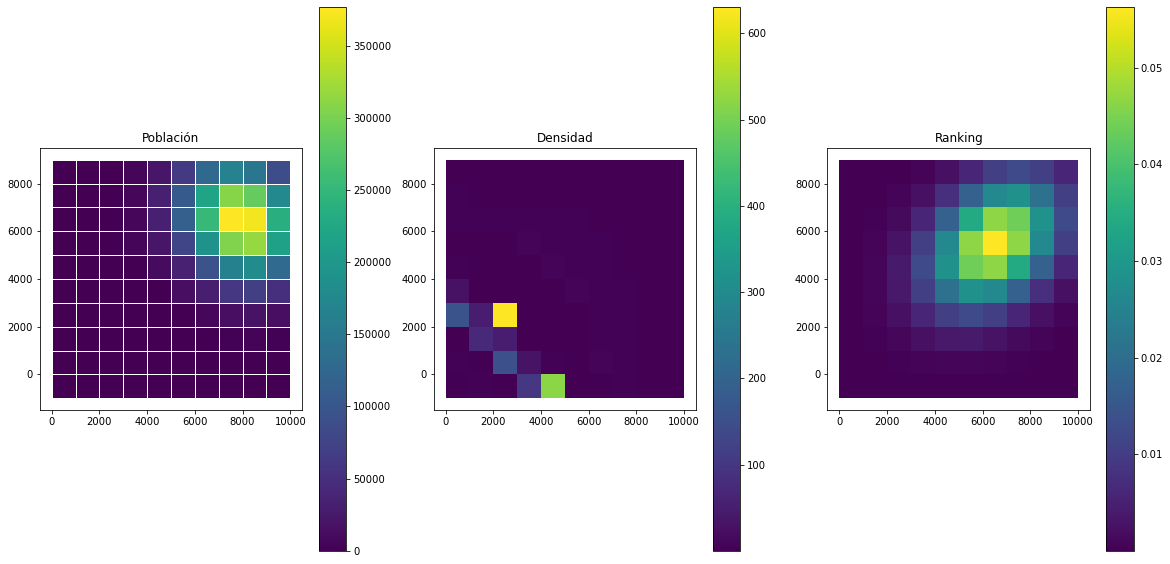

In [53]:
Poblacion_Inicial_normal(grid, [8,2], [[3,1],[1,3]])
Ranking_Normal(grid, [6,3], [[3,1],[-1,3]])
Graficar(grid)

K=Actualizacion(grid,200)
Graficar(K)